(sec-dft)=
# Discrete Fourier Transform

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
from scipy.integrate import cumtrapz

dpi = 300
transparent = True
PI = np.pi
TWO_PI = 2*PI
NUM = 44000
show = False

sns.set_theme('paper')
sns.set_style("whitegrid")

def lineplot(x, y, filename=None, title=None, xlim=None, ylim=None, ax=None, fig=None, **kargs):
    if not ax or not fig:
        fig, ax = plt.subplots()
    ax.plot(x, y, **kargs)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if show:
        plt.show()
    if filename != None:
        fig.savefig(filename, bbox_inches='tight',
                    transparent=transparent, pad_inches=0, dpi=dpi)
    return fig, ax

Up to this point, we considered continuous signals $y(t)$.
In section [Fourier Series](sec-fourier), we started with **continuous periodic fuctions**.
We generalized this concept to **continuous aperiodic fuctions** in section [Fourier Transform](sec-fourier-transform).
That's all fine but on a computer we are not dealing with continuous functions.
On a computer, audio is digitalized.
That is, we are dealing with **discrete signals**.

## Definitions

To deal with a **periodic** and **discrete** signal we switch from the *[Fourier transform](def-fourier-transform-exp)* to the *[discrete Fourier transform](def-discrete-fourier-transform)*.
If we want to handle a **non-periodic** and **discrete** signal we apply the *discrete-time Fourier transform (DTFT)* instead.
For audio signals the DTFT is not that relevant.

````{admonition} Discrete Fourier Series (DFS)
:name: def-fourier-series-exp-discrete
:class: definition

The *discrete Foruier series* $y: \mathbb{Z} \rightarrow \mathbb{C}$ in *exponential form* of a periodic and discrete function $y[n]$ is defined by

$$y[n] = \sum\limits_{k=0}^{N-1} c^*[k] \cdot e^{i\frac{2\pi}{N}kn}, \quad n \in \mathbb{Z},$$

which are harmonics of a fundamental frequency $1/N$, for some positive integer $N$ (the period of the signal).
````

This looks very similar to the [Fourier series](def-fourier-series-exp) except that $e^{ikn\frac{2\pi}{N}}$ is a discrete instead of a continuous function.
Instead of a sum of continuous functions, the *[discrete Fourier Series](def-fourier-series-exp-discrete)* is a sum of discrete functions.
Furthermore, there are only $N$ distinct coefficients $c^*[0], \ldots, c^*[N-1]$.
$y[n]$ is periodic and so is $c^*[k]$.

````{admonition} Discrete Fourier Transform (DFT)
:name: def-discrete-fourier-transform
:class: definition

The *discrete Foruier transform (DFT)* transforms of a sequence of $N$ *complex numbers* $y[0], \ldots, y[N-1]$ into another sequence of complex numbers $c[0], \ldots, c[N-1]$, such that

$$c[k] = \sum\limits_{n=0}^{N-1} y[n] \cdot e^{-i\frac{2\pi}{N}nk},$$

where $c[k]$ for $k = 0, \ldots, N-1$ are the coefficients of the *[discrete Fourier series](def-fourier-series-exp-discrete)*.
````

Similar to the *[Fourier transform](def-fourier-transform-exp)* there is an inverse transformation.

````{admonition} Inverse Discrete Fourier Transform (IDFT)
:name: def-inverse-discrete-fourier-transform
:class: definition

The *inverse discrete Fourier transform IDFT* transforms a sequence of $N$ *complex numbers* $c[0], \ldots, c[N-1]$ into another sequence of complex numbers  $y[0], \ldots, y[N-1]$, such that 

$$y[n] = \frac{1}{N} \sum\limits_{k=0}^{N-1} c[k] \cdot e^{i\frac{2\pi}{N}kn},$$

where $c[k]$ for $k = 0, \ldots, N-1$ are the coefficients of the *[discrete Fourier transform](def-discrete-fourier-transform)*.
````

Note that the *[inverse discrete Fourier transform  IDFT](def-inverse-discrete-fourier-transform)* is a specific examle of a *[discrete Fourier series](def-fourier-series-exp-discrete)*.

## Example

Suppose the following signal is given

$$y(t) = \underbrace{5}_{\text{DC}} + \underbrace{2 \cos(2\pi t - \pi/2)}_{\text{1 Hz}} + \underbrace{3 \cdot \cos(4\pi t)}_{\text{2 Hz}}.$$

Let's sample $y(t)$ at 4 times per second, i.e. a *sample rate* $f_s$ of 4 Hz from $t = 0$ to $t=3/2$.
The values of the discrete samples are given by:

$$y[n] = 5 + 2 \cos(\pi/3 n - \pi/2) + 3 \cos(\pi n)$$

for $t = n / 4$.
We get $y[0] = 8$, $y[1] = 4$, $y[2] = 8$, $y[3] = 0$, $y[4] = y[0]$, ...
Clearly $N = 4$ since we have frequencies of 1 and 2 Hz and a sample frequency $f_s$ of 4 Hz.

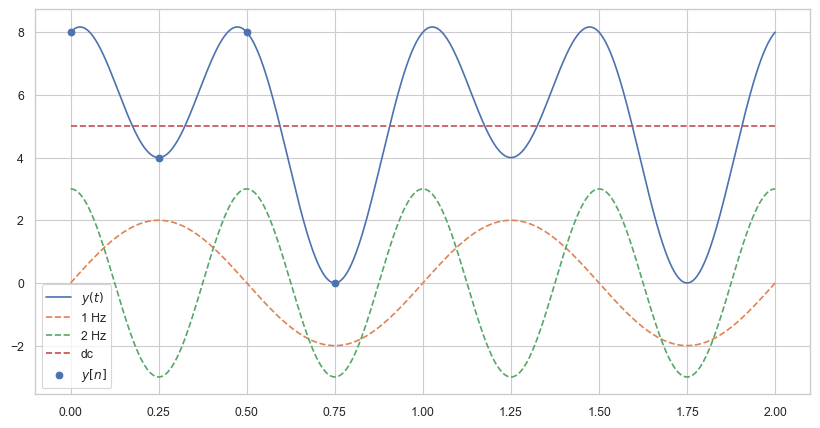

In [2]:
y1 = lambda t: 2 * np.cos(2*np.pi*t - np.pi/2)
y2 = lambda t: 3 * np.cos(4*np.pi*t)
dc = lambda t: np.ones(len(t))*5
y = lambda t: dc(t) + y1(t) + y2(t)

t = np.linspace(0, 2, 1000)
n = np.linspace(0, 1, 5)[:-1]
y_n = y(n)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, y(t), label=r'$y(t)$')
ax.plot(t, y1(t), label=r'1 Hz', linestyle='--')
ax.plot(t, y2(t), label=r'2 Hz', linestyle='--')
ax.plot(t, dc(t), label=r'dc', linestyle='--')
ax.scatter(n, y_n, label=r'$y[n]$', marker='o')
fig = ax.legend()

Let us implement the *DFT* and *IDFT* using ``Python``.
The following code is inefficient but suffice for our purposes.

### DFT

```isc
(
~dft = {arg y, k;
    var m = y.size, result = 0;
    for(0, m-1, {
        arg n;
        result = result + (y[n] * exp(Complex(0,-1) * 2 * pi / m * n * k));
    });
    result;
};
)
```

```isc
y = [8, 4, 8, 0];
c = Array.fill(4, {arg i; i}).collect({arg i; ~dft.(y, i)});

/* [ 
Complex( 20.0, 0.0 ), 
Complex( 0.0, -4.0 ), 
Complex( 12.0, 1.4695761589768e-15 ), 
Complex( -8.8817841970013e-16, 4.0 ) ]
*/

```

In [3]:
def dft(y, k):
    N = len(y)
    result = 0
    for n in range(N):
        result += y[n] * np.exp(-1j * 2*np.pi/N * n * k)
    return result

In [4]:
c_k = [dft(y_n, k) for k in range(len(y_n))]

``c_k`` contains the values of our coefficients, i.e. $c[k]$ for $k = 0, 1, 2, 3$ **Hz**, i.e.,

$$c[0] = 20, c[1] = -4i, c[2] = 12, c[3] = +4i.$$

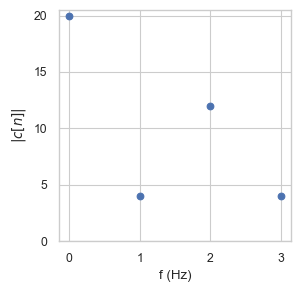

In [5]:
fig, ax = plt.subplots(figsize=(3,3))
f = np.array([0, 1, 2, 3])
ax.scatter(f, np.abs(np.array(c_k)), label=r'$|c[n]|$')
ax.set_ylim((0,20.5))
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'$|c[n]|$');

Since we have 4 samples, i.e., $N=4$, we have to divide by 4 to compute the respective amplitudes.
Since $y(t)$ is a real-valued function we already know that

$$c[n] = \overline{c[N-n]}.$$

and the amplitude is given by 

$$\frac{2}{N} \cdot c[n], \text{ if there is another } c[N-n] $$

otherwise it is

$$\frac{1}{N} \cdot c[n]$$

Furthermore, because of *[Nyquist–Shannon sampling theorem](theorem-sampling)* we can not compute the amplitude (and phase) of frequencies greater than 2 Hz.
In general, all $c[n]$ with $n > \frac{N}{2}$ are **invalid** because of *[aliasing](def-aliasing)*.
Therefore, $c[3] = 4i$ is ''incorrect''.
We can not distinguish the sinosoid of frequency $1$ from the sinosoid of frequency $3 = 1 + f_s$.
Therefore, 

$$c[1] = 2 \cdot 4i = 8i.$$

In summary,

$$A_0 = \frac{1}{N} c[0] = \frac{20}{4} = 5, \quad A_1 = \frac{2}{4} c[1] = \frac{8}{4} = 2, \quad A_2 = \frac{1}{4} c[2] = \frac{12}{4} = 3$$

Now you might wonder what happened to the [complex number](sec-complex-numbers) $c[1] = -4i$?
Remember, multiplying by $i$ equates to a counterclockwise rotation by 90 degrees.
The ''cosine-part'' of the complex number represents the real part.
Therefore, the **phase** of the cosine with the fundamental frequency is shifted by $-\pi/2$.
Which is true for $y(t)$.

### IDFT

Let's now apply the IDFT:

```isc
(
~idft = {arg y, k;
    var m = y.size, result = 0;
    for(0, m-1, {
        arg n;
        n.postln;
        result = result + (y[n] * exp(Complex(0,1) * 2 * pi / m * n * k));
    });
    result / m;
};
)
```

```isc
~iy = Array.fill(4, {arg i; i}).collect({arg i; ~idft.(c, i)});

/* [ 
Complex( 8.0, -6.6613381477509e-16 ), 
Complex( 4.0, -2.2884754904439e-17 ), 
Complex( 8.0, 6.6613381477509e-16 ), 
Complex( 7.7715611723761e-16, 1.2475315540518e-15 ) ]
 */
```

In [6]:
def idft(c, n):
    N = len(c)
    result = 0
    for k in range(N):
        result += c[k] * np.exp(1j * 2*np.pi/N * k * n)
    return 1/N * result

In [7]:
iy_n = [idft(c_k, n) for n in range(len(c_k))]

If we neglect the small numerical errors, we get the correct function values $y[n]$ for $n = 0, 1, 2, 3$ back again.
The imaginary part of the complex numbers are approximately zero because $y(t)$ is a real-valued function.

## Fast Fourier Transform

TODO

## FFT in SuperCollider

TODO

To compute the DFT and IDFT in [SuperCollider (SC)](https://supercollider.github.io/) we use the FFT and IFFT respectively.
For that purpose SC offers us a [FFT](https://doc.sccode.org/Classes/FFT.html) and [IFFT](https://doc.sccode.org/Classes/IFFT.html) unit generator, respectively.

```isc

(
{
    var in, chain, freq = 200;
    in = SinOsc.ar(freq)
    chain = FFT(LocalBuf(2048), in);
    IFFT(chain) // inverse FFT
}.play;
)

```